# Deconvolution Analysis (DANA)

In [148]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [149]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import time

In [150]:
from dataclasses import dataclass

In [151]:
import invisible_cities.core.system_of_units  as units
from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.io.dst_io    import load_dst
from invisible_cities.core.core_functions import in_range

In [152]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [153]:
from nextflex.core import Setup
from nextflex.core import KEY_sensor_fibres 
from nextflex.core import KEY_sensor_pmts   
from nextflex.core import S1_time           
from nextflex.core import SIPM_ids
from nextflex.core import get_sipm_postions
from nextflex.core import get_sensor_response

In [154]:
from nextflex.graphics_reco   import plot_hits3d

In [155]:
from  tics.stats_tics import bin_data_with_equal_bin_size
from tics.pd_tics   import get_index_slice_from_multi_index
from tics.util_tics   import find_nearest

In [156]:
from nextflex.types import EventHits

In [371]:
from nextflex.types import  ResponseSiPM
from nextflex.reco_functions import get_sipm_response
from nextflex.reco_functions import get_sipm_positions
from nextflex.reco_functions import get_event_sipm
from nextflex.reco_functions import get_sipm_event_hits
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxel_distances

In [201]:
from nextflex.graphics_reco   import plot_hits3d
from nextflex.graphics_reco   import plot_hits_projections
from nextflex.graphics_reco   import plot_hits_xy
from nextflex.graphics_reco   import bin_hits
from nextflex.graphics_reco   import bin_hits_xy
from nextflex.analysis_graphics import plot_multiple_tracks

In [159]:
from nextflex.tracks_dst import event_reco_hits

In [160]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [181]:
from nextflex.reco_functions import voxelize_hits

In [162]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from skimage.measure import label, regionprops
from skimage import data, util
from skimage.measure import label
from skimage.measure._regionprops import RegionProperties

In [163]:
from nextflex.reco_image_functions import label_slice
from nextflex.reco_image_functions import select_slice_by_label
from nextflex.reco_image_functions import image_from_df
from nextflex.reco_image_functions import detector_grid
from nextflex.reco_image_functions import Point
from nextflex.reco_image_functions import get_psf
from nextflex.reco_image_functions import print_region_properties

In [164]:
from invisible_cities. reco.deconv_functions import deconvolution_input
from invisible_cities. reco.deconv_functions import richardson_lucy
from invisible_cities. reco.deconv_functions import deconvolve
from invisible_cities.cities.beersheba         import DeconvolutionMode
from invisible_cities.  reco.deconv_functions  import InterpolationMethod
from invisible_cities.cities.beersheba         import CutType
from invisible_cities.core.core_functions import shift_to_bin_centers

In [165]:
from nextflex.deconvolution import lr_deconvolution

## Code

In [166]:
def rebin_time(df : pd.DataFrame)->pd.Series:
        """
        takes the mean time and the energy sum

        """
        d = {}
        d['time'] = df['time'][0]
        d['charge'] = df['charge'].sum()
        return pd.Series(d)


## Setup

In [167]:
FDATA = os.environ['FLEXDATA']
testDir  = os.path.join(FDATA,"testSetupData")
print(f"test dir = {testDir}")

test dir = /Users/jj/Development/flexdata/testSetupData


In [168]:
setbb = Setup(flexDATA = testDir,
              tpConfig = "FLEX100_M6_O6.EL8bar.bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu
        analysis directory           = /Users/jj/Development/flexdata/testSetupData/analysis/FLEX100_M6_O6.EL8bar.bb0nu
        number of h5 files in dir    = 1
        sipm map at                  = /Users/jj/Development/flexdata/testSetupData/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/testSetupData/kdsts/FLEX100_M6_O

In [169]:
setbb.ifnames[0]

'/Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5'

In [170]:
setbb.pitch

15.55

In [171]:
setbb.mc_config()

,param_value
param_key,
num_events,4
TP_SiPM_binning,1.000000 mus
/Geometry/NextFlex/e_lifetime,1000. ms
/Geometry/NextFlex/el_gap_length,10. mm
/Geometry/NextFlex/el_field_int,16. kilovolt/cm
/Geometry/NextFlex/tp_teflon_thickness,6. mm
/Geometry/NextFlex/tp_teflon_hole_diam,6. mm
/Geometry/NextFlex/tp_sipm_sizeX,1.3 mm
/Geometry/NextFlex/tp_sipm_pitchX,15.55 mm


## Compute EventHits

In [175]:
ifname = setbb.ifnames[0]

### Pre-selection

In [238]:
ecut       = 5     # minimum energy 5 pes
bin_size   = 20    # vox size 20 mm (larger than pitch)
contiguity = 35    # > 2 x pitch

In [239]:
evt= 0

In [240]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 0, event id = 212 nof gtracks = 3


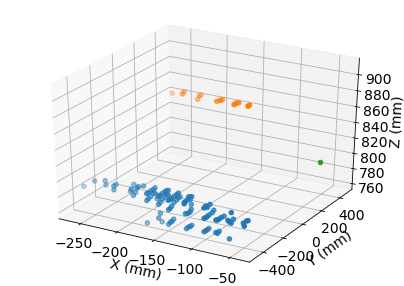

In [241]:
plot_multiple_tracks(GTRKS, figsize = (7,5), fontsize=10)

In [242]:
voxdfs = [GTRKS[i].voxels_df for i in range(1, len(GTRKS))]
voxdfs

[             x           y           z  energy  nhits
 0   -77.750000 -155.500000  904.000000    12.0    2.0
 1  -155.500000 -217.699997  908.000000    12.0    1.0
 2   -93.300003 -171.050003  904.051813   193.0    9.0
 3   -93.300003 -186.600006  904.000000    88.0    7.0
 4  -171.050003 -202.149994  905.000000     6.0    1.0
 5  -113.462288 -171.050003  904.201695   590.0   21.0
 6  -114.251578 -155.500000  903.302632   380.0   20.0
 7   -93.300003 -155.500000  903.862069    87.0    6.0
 8  -155.500000 -202.149994  909.411765    17.0    2.0
 9   -93.300003 -139.949997  902.848485    33.0    5.0
 10 -115.274850 -188.788178  904.191617   334.0   20.0
 11 -139.949997 -186.600006  902.000000     6.0    1.0
 12  -77.750000 -171.050003  903.687500    16.0    2.0
 13 -139.949997 -155.500000  905.000000     6.0    1.0
 14 -114.175342 -139.949997  902.849315    73.0    9.0
 15 -139.949997 -171.050003  905.000000     7.0    1.0,
            x      y      z  energy  nhits
 0 -62.200001  466.5 

In [256]:
evt = 1

In [257]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 1, event id = 213 nof gtracks = 4


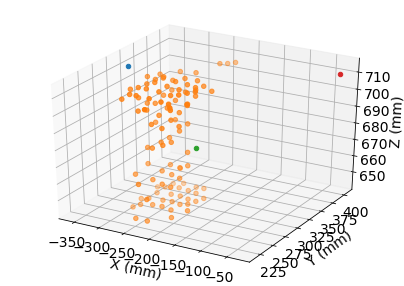

In [258]:
plot_multiple_tracks(GTRKS, figsize = (7,5), fontsize=10)

In [259]:
voxdfs = [GTRKS[i].voxels_df for i in range(0, len(GTRKS))]
voxdfs

[            x           y           z  energy  nhits
 0 -357.649994  318.176917  710.846154    13.0    2.0,
               x           y           z  energy  nhits
 0   -295.450012  248.800003  707.000000     7.0    1.0
 1   -295.450012  264.350006  710.000000     6.0    1.0
 2   -295.450012  295.450012  712.000000     7.0    1.0
 3   -295.450012  318.774994  709.500000    12.0    2.0
 4   -279.899994  248.800003  644.000000     7.0    1.0
 ..          ...         ...         ...     ...    ...
 110 -186.600006  279.899994  647.366667    30.0    4.0
 111 -186.600006  279.899994  712.000000     6.0    1.0
 112 -186.600006  295.450012  646.000000     6.0    1.0
 113 -186.600006  311.000000  707.000000     6.0    1.0
 114 -171.050003  248.800003  649.000000     7.0    1.0
 
 [115 rows x 5 columns],
             x           y      z  energy  nhits
 0 -248.800003  342.100006  664.0     6.0    1.0,
       x           y      z  energy  nhits
 0 -31.1  404.299988  710.0     6.0    1.0]

In [260]:
evt = 2

In [261]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 2, event id = 214 nof gtracks = 4


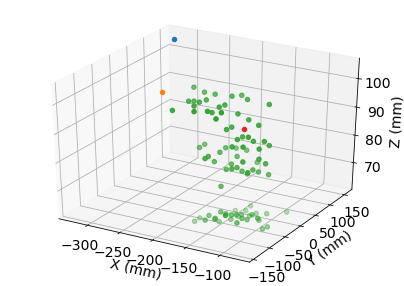

In [262]:
plot_multiple_tracks(GTRKS, figsize = (7,5), fontsize=10)

In [263]:
voxdfs = [GTRKS[i].voxels_df for i in range(0, len(GTRKS))]
voxdfs

[            x      y      z  energy  nhits
 0 -326.549988  155.5  104.0     6.0    1.0,
         x          y      z  energy  nhits
 0 -233.25 -62.200001  103.0     6.0    1.0,
              x           y           z  energy  nhits
 0  -202.149994  -31.100000  104.000000     6.0    1.0
 1  -186.600006 -124.400002  103.000000     6.0    1.0
 2  -186.600006  -77.750000  103.000000    12.0    2.0
 3  -186.600006  -62.200001  102.000000     6.0    1.0
 4  -186.600006  -31.100000  103.000000     8.0    1.0
 ..         ...         ...         ...     ...    ...
 85  -77.750000  -77.750000   94.461538    13.0    2.0
 86  -77.750000  -62.200001   63.500000    12.0    2.0
 87  -77.750000  -62.200001   82.000000    36.0    5.0
 88  -77.750000  -62.200001   92.000000     6.0    1.0
 89  -77.750000    0.000000   64.000000     7.0    1.0
 
 [90 rows x 5 columns],
        x           y      z  energy  nhits
 0 -77.75 -139.949997  103.0     6.0    1.0]

In [264]:
evt = 3

In [265]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 3, event id = 215 nof gtracks = 1


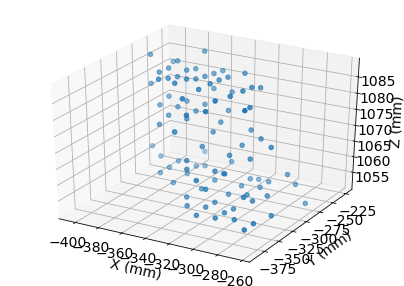

In [253]:
plot_multiple_tracks(GTRKS, figsize = (7,5), fontsize=10)

##### Energy cut may be too small. 

## Deconvolution

### Raw track

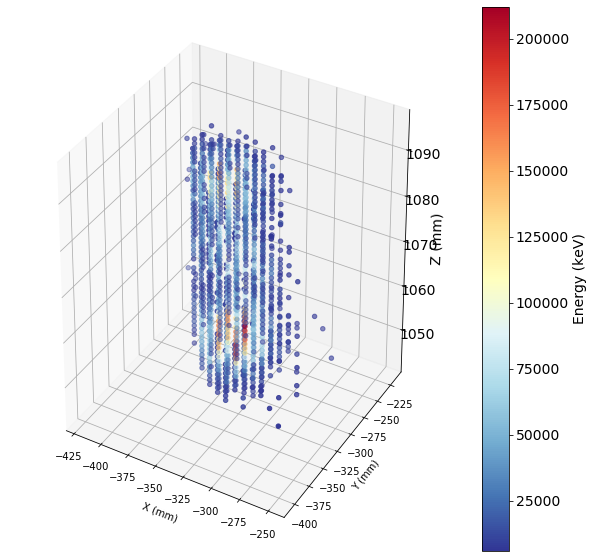

In [466]:
plot_hits3d(sipm_hits,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [467]:
binHits = bin_hits(sipm_hits)

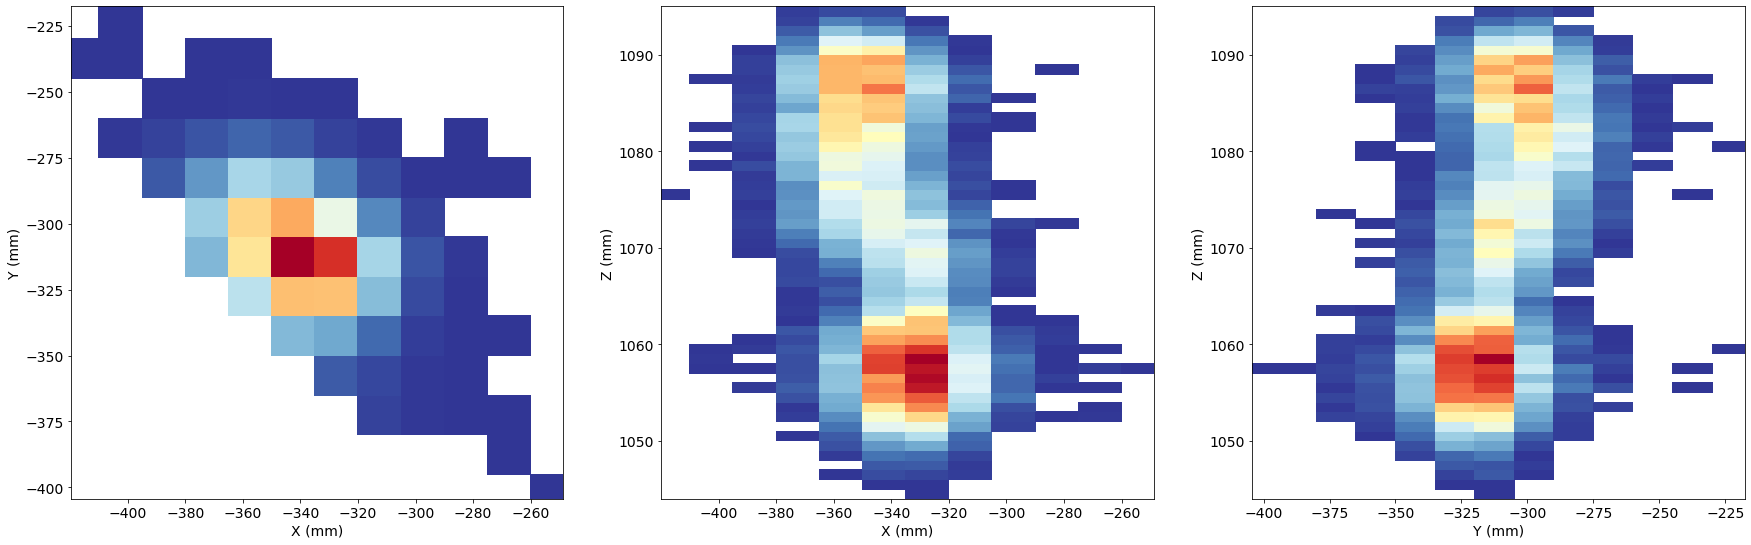

In [468]:
plot_hits_projections(sipm_hits, binHits,  masked=True, figsize=(30, 10))

### Prepare data

#### Deconvolution parameters

In [469]:
bin_size      = (3., 3.)
sample_width  = (15.5, 15.5)
inter_method    = InterpolationMethod.cubic

#### Total and max energy

In [470]:
etot = sipm_hits.df.energy.sum()
emax = sipm_hits.df.energy.max()
print(f" Total energy = {etot}, max energy = {emax}")

 Total energy = 36254, max energy = 212


#### Slicing in z 

In [471]:
zsl = np.unique(sipm_hits.df.z.values)
print(f"number of z slices = {len(zsl)}")

number of z slices = 52


In [472]:
len_slices = [len(sipm_hits.df[sipm_hits.df.z == zs]) for zs in zsl]

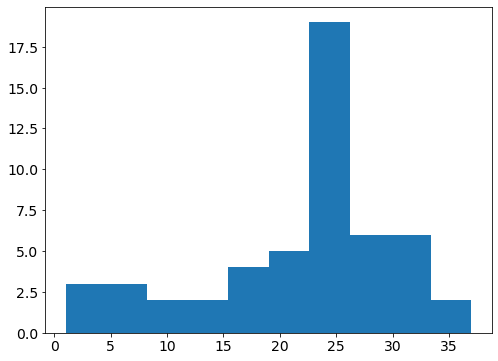

In [473]:
_ = plt.hist(len_slices)

In [474]:
lmax = np.max(len_slices)
ilmax = np.argmax(len_slices)
print(f" length of slice (max) ={lmax}, i = {ilmax}")

 length of slice (max) =37, i = 13


### Deconvolve longer slice

In [475]:
dfzm = sipm_hits.df[sipm_hits.df.z == zsl[ilmax]].reset_index(drop=True)

In [476]:
dfzm.head()

,x,y,z,energy
0,-248.800003,-404.299988,1057.0,6
1,-264.350006,-388.750000,1057.0,6
2,-311.000000,-373.200012,1057.0,7
3,-279.899994,-373.200012,1057.0,6
4,-264.350006,-373.200012,1057.0,6


In [477]:
print(f"""
Larger slice in z at position = {zsl[ilmax]}
numper of hits                = {len(dfzm)}
max energy =                  = {dfzm.energy.max()}
        """)


Larger slice in z at position = 1057.0
numper of hits                = 37
max energy =                  = 184
        


In [478]:
dfzn = dfzm.copy()

In [479]:
dfzn['energy'] = dfzn.energy / emax

In [480]:
dfzn.energy.max()

0.8679245283018868

In [481]:
dfzn.head()

,x,y,z,energy
0,-248.800003,-404.299988,1057.0,0.028302
1,-264.350006,-388.750000,1057.0,0.028302
2,-311.000000,-373.200012,1057.0,0.033019
3,-279.899994,-373.200012,1057.0,0.028302
4,-264.350006,-373.200012,1057.0,0.028302


In [482]:
binHits = bin_hits_xy(dfzn)

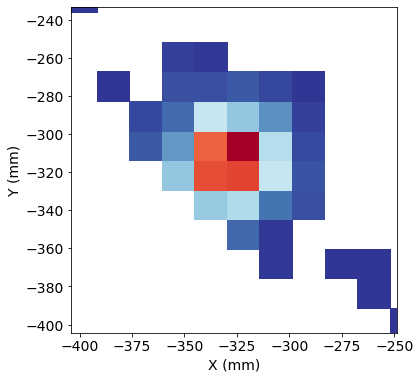

In [483]:
plot_hits_xy(dfzn, binHits,  masked=True, figsize=(6, 6))

##### Notice isolated clusters (cut at 5 pes is low)

#### Labelling a slice in z and selecting by label

In [484]:
sckl = label_slice(dfzn)

##### Label matrix shows 5 regions, only one has a cluster of SiPMs all the others are isolated SiPMs

In [485]:
sckl.lbl

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0],
       [0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0],
       [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0],
       [0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [486]:
len(sckl.prp)

3

##### Properties has 3 regions (corresponding to labeling)

In [487]:
print_region_properties(sckl.prp)

 number of regions = 3

        region      = 0
        label       = 1
        area        = 1
        coordinates = [[ 0 11]]
        intensiy    = [[0.02830189]]
        

        region      = 1
        label       = 2
        area        = 32
        coordinates = [[1 8]
 [2 6]
 [2 7]
 [3 5]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 4]
 [4 5]
 [4 6]
 [4 7]
 [4 8]
 [4 9]
 [5 3]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [5 8]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 6]
 [6 7]
 [6 8]
 [7 4]
 [7 5]
 [7 6]
 [7 7]
 [7 8]]
        intensiy    = [[0.         0.         0.         0.         0.         0.
  0.02830189 0.        ]
 [0.         0.         0.         0.         0.0754717  0.05188679
  0.         0.        ]
 [0.         0.         0.         0.24528302 0.16509434 0.0990566
  0.06603774 0.04245283]
 [0.         0.         0.25       0.74056604 0.71698113 0.32075472
  0.06132075 0.03301887]
 [0.         0.09433962 0.28773585 0.75471698 0.86792453 0.24528302
  0.0754717  0.        ]
 [0.03301887 0.03301887 0.1

##### In the selection by size we require a size of at least 2 (no isolated SiPMs)

In [488]:
dfzs = select_slice_by_label(dfzn, sckl, min_size=2)

In [489]:
dfzs.head()

,x,y,energy
0,-248.800003,-404.299988,0.028302
1,-373.200012,-311.000000,0.075472
2,-373.200012,-295.450012,0.051887
3,-357.649994,-326.549988,0.245283
4,-357.649994,-311.000000,0.165094


In [490]:
print(f""" 
selection in z:
xmin = {dfzs.x.min()}
xmax = {dfzs.x.max()}
ymin = {dfzs.y.min()}
ymax = {dfzs.y.max()}

""")

 
selection in z:
xmin = -373.20001220703125
xmax = -248.8000030517578
ymin = -404.29998779296875
ymax = -279.8999938964844




In [491]:
xx = dfzs.x.mean()
yy = dfzs.y.mean()
zz = dfzn.z.values[0]
print(f"xmean = {xx}, ymean={yy} zmean = {zz}")

xmean = -315.7513910929362, ymean=-336.9166658189562 zmean = 1057.0


#### Prepare detector grid

In [492]:
det_grid = detector_grid(dfzs, bin_size)

In [493]:
izn = image_from_df(dfzs, det_grid, sample_width)

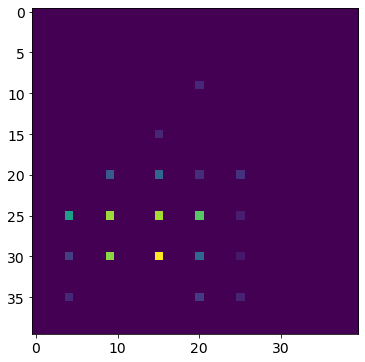

In [494]:
plt.imshow(izn.T)

#### Interpolation 

In [495]:
interpolator = deconvolution_input(sample_width, 
                                   det_grid, 
                                   inter_method)

In [496]:
inter_values, inter_pos = interpolator((dfzs.x.values, dfzs.y.values), dfzs.energy.values)

In [497]:
len(inter_values.flatten())

1681

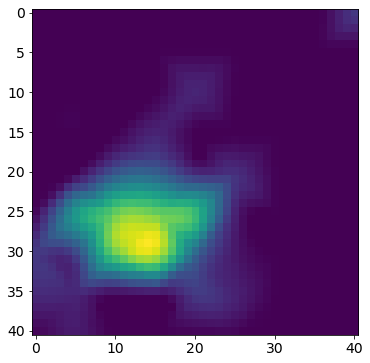

In [498]:
plt.imshow(inter_values.T)

In [499]:
dfzi = pd.DataFrame({'x' : inter_pos[0].flatten(), 
                     'y' : inter_pos[1].flatten(), 
                     'energy' : inter_values.flatten() })

In [500]:
dfzi

,x,y,energy
0,-371.700012,-402.799988,0.000026
1,-371.700012,-399.799988,0.000099
2,-371.700012,-396.799988,0.000161
3,-371.700012,-393.799988,0.000180
4,-371.700012,-390.799988,0.000119
...,...,...,...
1676,-251.700012,-294.799988,0.000203
1677,-251.700012,-291.799988,0.000070
1678,-251.700012,-288.799988,0.000021
1679,-251.700012,-285.799988,0.000000


In [501]:
binHits = bin_hits_xy(dfzi,
            xr = (dfzi.x.min(), dfzi.x.max()),
            yr = (dfzi.y.min(), dfzi.y.max()),
            pitch = (1, 1))

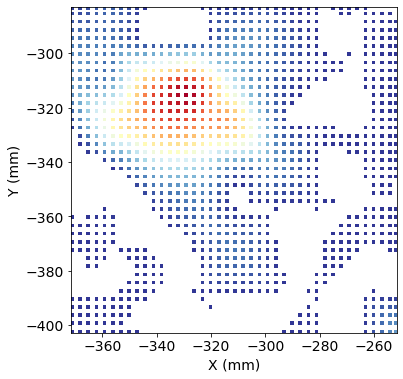

In [502]:
plot_hits_xy(dfzi, binHits,  masked=True, figsize=(6, 6))

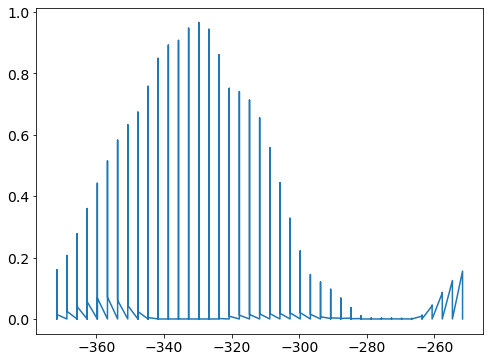

In [503]:
plt.plot(dfzi.x, dfzi.energy)

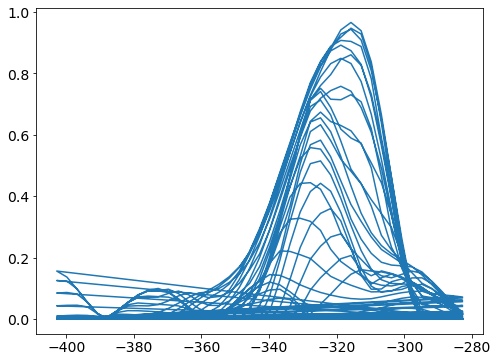

In [504]:
plt.plot(dfzi.y, dfzi.energy)

#### PSF

In [505]:
pspath = os.path.join(FDATA, "PSFs")
psfname1 = "PSF_flex_EL_diff.h5"
psfname2 = "PSF_flex_EL_diff_3mm.h5"

In [506]:
xyz = Point(xx,yy,zz)

In [507]:
psf_deco = get_psf(pspath, psfname2, dfzs, xyz)

In [508]:
psf_deco.shape

(66, 66)

#### RL deconvolution

In [509]:
start_time = time.perf_counter() 
deconv_image  = np.nan_to_num(richardson_lucy(inter_values, psf_deco, 90, 1e-10))
                                                     
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'LR from IC run in {run_time} seconds')

LR from IC run in 0.08997935897787102 seconds


In [510]:
deconv_image.T.shape

(41, 41)

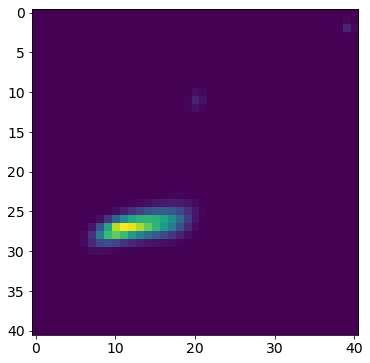

In [511]:
plt.imshow(deconv_image.T)

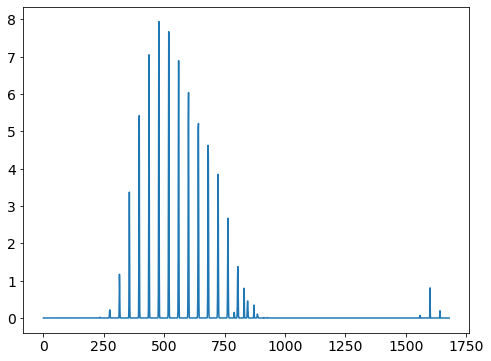

In [512]:
plt.plot(deconv_image.flatten())

In [513]:
dcdf = pd.DataFrame({"x" : inter_pos[0],
                     "y" : inter_pos[1],
                    "energy" : deconv_image.flatten()})

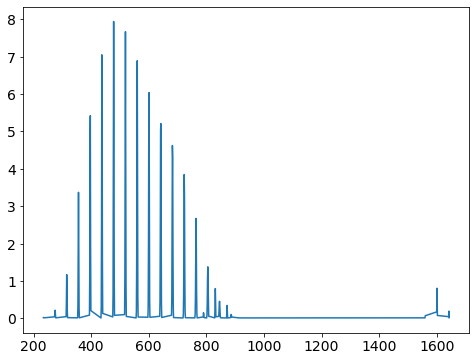

In [515]:
plt.plot(dcdf.energy[dcdf.energy>0.01])

In [522]:
dcdfs = dcdf[dcdf.energy>1]

In [523]:
binHits = bin_hits_xy(dcdfs,
            xr = (dcdfs.x.min(), dcdfs.x.max()),
            yr = (dcdfs.y.min(), dcdfs.y.max()),
            pitch = (1, 1))

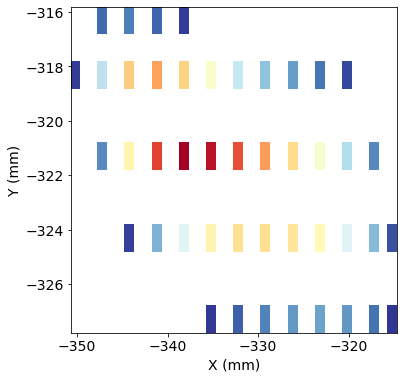

In [524]:
plot_hits_xy(dcdfs, binHits,  masked=True, figsize=(6, 6))

### Deconvolution all slices

In [129]:
pspath = os.path.join(FDATA, "PSFs")
psfname = "PSF_flex_EL_diff.h5"
psfname2 = "PSF_flex_EL_diff_3mm.h5"

In [527]:
start_time = time.perf_counter() 
dcHits = lr_deconvolution(sipm_hits,
                          pspath,
                          psfname2,
                         bin_size     = (3., 3.),
                         sample_width = (15.5, 15.5),
                         inter_method = InterpolationMethod.cubic,
                         n_iter       = 90,
                         e_min        = 0.1,
                         interactive  = 0)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'LR from IC run in {run_time} seconds')

warning min_hits < = 2: skipping
warning min_hits < = 2: skipping
warning min_hits < = 2: skipping
LR from IC run in 6.9575882839853875 seconds


In [528]:
dcHits

<EventHits>
        event number = 215
        event type   = None
        topology     = None
        Columns = ('x', 'y', 'z', 'energy')
        

In [529]:
dcHits.df

,x,y,z,energy
0,-326.549988,-311.000000,1044.0,0.028302
1,-342.100006,-326.549988,1045.0,0.033019
2,-326.549988,-311.000000,1045.0,0.033019
3,-344.149994,-316.049988,1046.0,0.481661
4,-344.149994,-313.049988,1046.0,1.336839
...,...,...,...,...
2670,-356.700012,-297.500000,1094.0,1.257230
2671,-353.700012,-300.500000,1094.0,0.234879
2672,-353.700012,-297.500000,1094.0,0.175289
2673,-357.649994,-311.000000,1095.0,0.028302


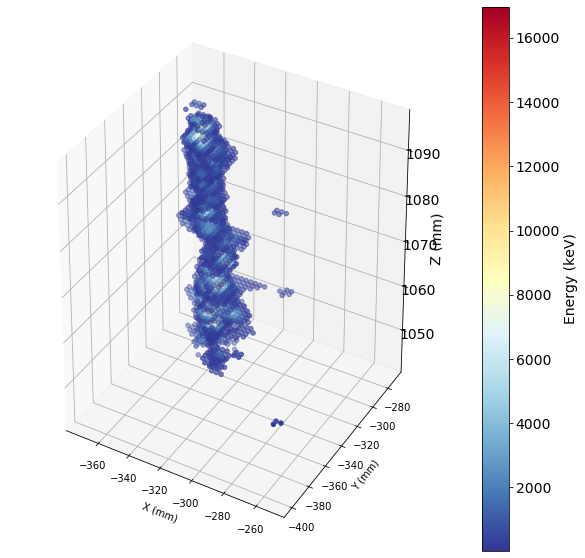

In [530]:
plot_hits3d(dcHits,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [531]:
len(dcHits.df)

2675

In [421]:
dcHits2 =dcHits.df[dcHits.df.energy>0.2]

(array([1537.,  465.,  235.,  138.,  116.,   61.,   39.,   26.,   18.,
          17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

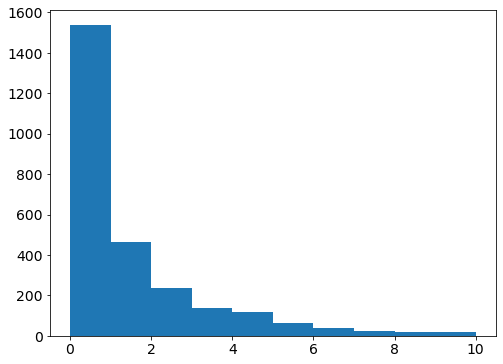

In [533]:
plt.hist(dcHits.df.energy, range=(0,10))

In [423]:
len(dcHits2)

22872

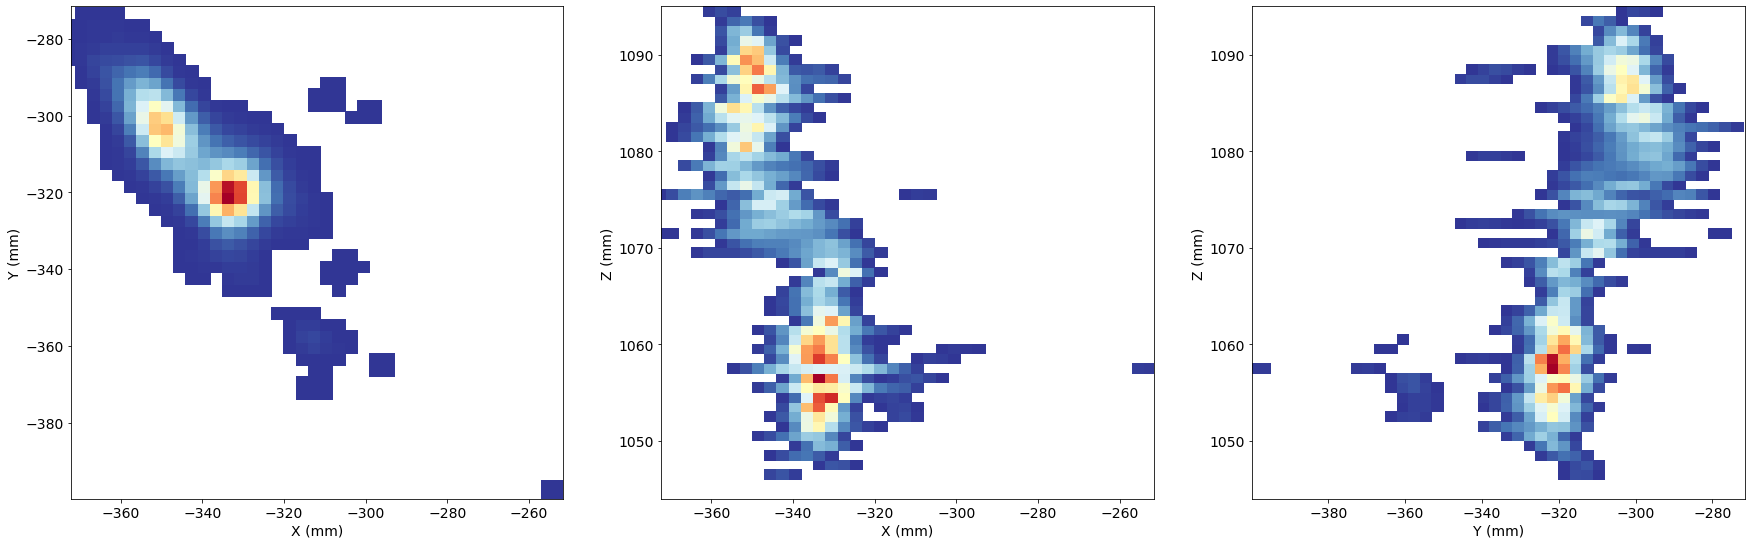

In [534]:
binHits = bin_hits(dcHits, pitch = (3,3))
plot_hits_projections(dcHits2, binHits,  masked=True, figsize=(30, 10))

In [535]:
dcHits

<EventHits>
        event number = 215
        event type   = None
        topology     = None
        Columns = ('x', 'y', 'z', 'energy')
        

## Make tracks from deconvolved hits

In [539]:
bin_size=10
contiguity=20
voxHits = voxelize_hits(dcHits, bin_size)


In [540]:
voxHits

<VoxelHits>
        event number = 215
        voxel bin    = 10
        barycenter   = True
        xyz_bins     = 0.001372
        Columns      = ('x', 'y', 'z', 'energy', 'nhits')
        

In [541]:
voxHits.df

,x,y,z,energy,nhits
0,-363.250000,-309.062373,1071.000000,0.253103,2.0
1,-363.250000,-301.600006,1083.000000,0.341998,1.0
2,-363.799988,-302.149994,1087.000000,0.169265,1.0
3,-363.506199,-293.651781,1077.504094,2.525741,5.0
4,-363.629995,-294.759894,1082.437424,9.562572,15.0
...,...,...,...,...,...
137,-300.850458,-298.799402,1059.000000,0.687908,3.0
138,-305.837880,-293.609898,1075.000000,0.820691,3.0
139,-295.811651,-364.011399,1059.000000,0.923416,4.0
140,-297.250000,-298.255994,1059.000000,0.573944,2.0


In [542]:
start_time = time.perf_counter() 
gtracks  = make_track_graphs(voxHits, contiguity)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f' make track-graphs in {run_time} seconds')
print(f" event in list {evt}, event id = {voxHits.event_id} nof gtracks = {len(gtracks)}")

 make track-graphs in 0.1245621330162976 seconds
 event in list 3, event id = 215 nof gtracks = 2


In [544]:
start_time = time.perf_counter() 
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=10)\
                             for gtr in gtracks]
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'GTrks in {run_time} seconds')

GTrks in 0.45103575199027546 seconds


In [545]:
from tics.graphics_reco import plot_gtrack

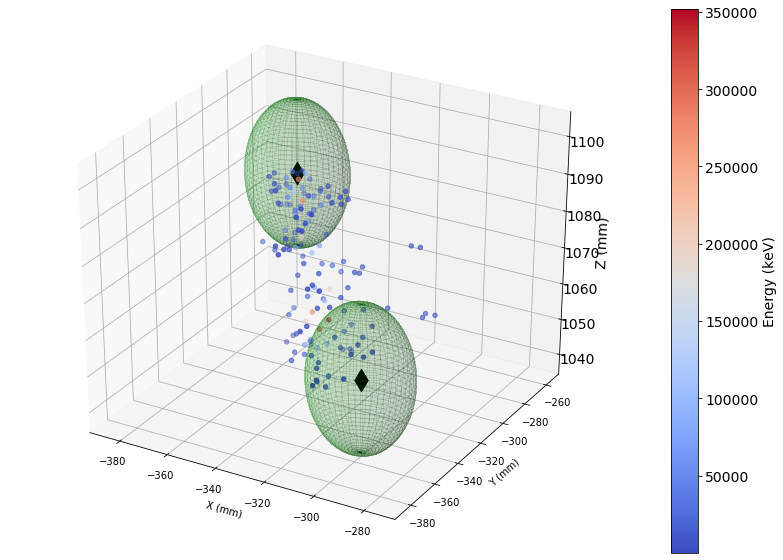

In [546]:
plot_gtrack(GTRKS[0], rb=20)

In [547]:
GTRKS[1].voxels_df

,x,y,z,energy,nhits
0,-254.120267,-396.799988,1057.0,0.9985,2.0
